In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import os
from google.colab import drive

def getAOC(data):
  AOC = []
  close = data['종가']

  # aoc = (금일 종가 - 전일 종가) / 전일 종가
  for i in range(len(close)):
    aoc_value = ((close[i] - close[i-1]) / close[i-1]) * 100
    if(i % 494 == 0):
      aoc_value = 0
    AOC.append(aoc_value)

  return AOC

drive.mount('/content/drive')

sub=pd.read_csv("./drive/MyDrive/Colab Notebooks/sample_submission.csv")
data=pd.read_csv("./drive/MyDrive/Colab Notebooks/train.csv")

#sort data by "종목명"
subject_Data=data.sort_values(by="종목명",inplace=False)
subject_Data.head()
subject_Data.columns

pv_s_data=pd.pivot_table(subject_Data,values=['거래량', '시가', '고가', '저가', '종가'],index=['종목코드','일자'])

pv_s_data["AOC"] = getAOC(pv_s_data)

divided = pv_s_data.index.get_level_values('종목코드').unique()

sliced_dataframes = []

for i in divided:
    sliced_data = pv_s_data.loc[i]
    sliced_dataframe = sliced_data.reset_index()
    sliced_dataframes.append(sliced_dataframe)

sliced_dataframes

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[           일자     거래량     고가     시가     저가     종가       AOC
 0    20210601  114966  14700  14700  14450  14600  0.000000
 1    20210602  109559  14700  14700  14450  14500 -0.684932
 2    20210603   96158  14650  14550  14450  14600  0.689655
 3    20210604  133900  14800  14600  14550  14700  0.684932
 4    20210607  511140  15550  14800  14750  15150  3.061224
 ..        ...     ...    ...    ...    ...    ...       ...
 489  20230523  641524   9900   9160   9160   9770  5.280172
 490  20230524  205243   9820   9770   9550   9740 -0.307062
 491  20230525  398326  10180   9660   9660  10040  3.080082
 492  20230526  196257  10150  10050   9850   9850 -1.892430
 493  20230530  201361  10040   9960   9640   9700 -1.522843
 
 [494 rows x 7 columns],
            일자      거래량    고가    시가    저가    종가       AOC
 0    20210601   480096  1190  1180  1155  1175  0.000000
 1    20210602   928675  1225  1190  1180  1210  2.978723
 2    20210603   508487  1230  1220  1190  1200 -0.826446
 3    202

In [24]:
# MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['거래량', '고가', '시가', '저가', '종가', 'AOC']
scaled = scaler.fit_transform(sliced_dataframes[3][scale_cols])
scaled

array([[0.13568761, 0.74376731, 0.76224784, 0.78162651, 0.75317348,
        0.48955916],
       [0.12245539, 0.76454294, 0.77665706, 0.81174699, 0.76022567,
        0.51580259],
       [0.06016822, 0.75069252, 0.77665706, 0.79668675, 0.76022567,
        0.48955916],
       ...,
       [0.0453256 , 0.20083102, 0.21037464, 0.15210843, 0.19605078,
        0.43386168],
       [0.04219952, 0.18698061, 0.21181556, 0.15813253, 0.17066291,
        0.34499136],
       [0.01185116, 0.16897507, 0.17723343, 0.17168675, 0.16925247,
        0.48132876]])

In [25]:
df = pd.DataFrame(scaled, columns=scale_cols)
df

,거래량,고가,시가,저가,종가,AOC
0,0.135688,0.743767,0.762248,0.781627,0.753173,0.489559
1,0.122455,0.764543,0.776657,0.811747,0.760226,0.515803
2,0.060168,0.750693,0.776657,0.796687,0.760226,0.489559
3,0.099272,0.743767,0.762248,0.774096,0.746121,0.437302
4,0.072518,0.736842,0.783862,0.766566,0.739069,0.463200
...,...,...,...,...,...,...
489,0.003281,0.191136,0.210375,0.213855,0.204513,0.489559
490,0.003620,0.185596,0.206052,0.206325,0.205924,0.497527
491,0.045326,0.200831,0.210375,0.152108,0.196051,0.433862
492,0.042200,0.186981,0.211816,0.158133,0.170663,0.344991


In [26]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop('종가', 1), df['종가'], test_size=0.2, random_state=0, shuffle=False)

<ipython-input-26-1202195c6716>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('종가', 1), df['종가'], test_size=0.2, random_state=0, shuffle=False)


In [27]:
import tensorflow as tf
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [28]:
WINDOW_SIZE=20
BATCH_SIZE=32

# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [29]:
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda

model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [30]:
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [35]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=50)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

In [36]:
history = model.fit(train_data,
                    validation_data=(test_data),
                    epochs=2000,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/2000
     11/Unknown - 0s 5ms/step - loss: 0.0019 - mse: 0.0038 
Epoch 1: val_loss improved from inf to 0.00129, saving model to tmp/ckeckpointer.ckpt
12/12 [==============================] - 0s 15ms/step - loss: 0.0019 - mse: 0.0037 - val_loss: 0.0013 - val_mse: 0.0026
Epoch 2/2000
11/12 [==========================>...] - ETA: 0s - loss: 0.0018 - mse: 0.0036
Epoch 2: val_loss improved from 0.00129 to 0.00120, saving model to tmp/ckeckpointer.ckpt
12/12 [==============================] - 0s 13ms/step - loss: 0.0018 - mse: 0.0036 - val_loss: 0.0012 - val_mse: 0.0024
Epoch 3/2000
 8/12 [===================>..........] - ETA: 0s - loss: 0.0018 - mse: 0.0036
Epoch 3: val_loss improved from 0.00120 to 0.00115, saving model to tmp/ckeckpointer.ckpt
12/12 [==============================] - 0s 15ms/step - loss: 0.0018 - mse: 0.0036 - val_loss: 0.0012 - val_mse: 0.0023
Epoch 4/2000
11/12 [==========================>...] - ETA: 0s - loss: 0.0017 - mse: 0.0034
Epoch 4: val_loss did not im

3/3 [==============================] - 0s 18ms/step


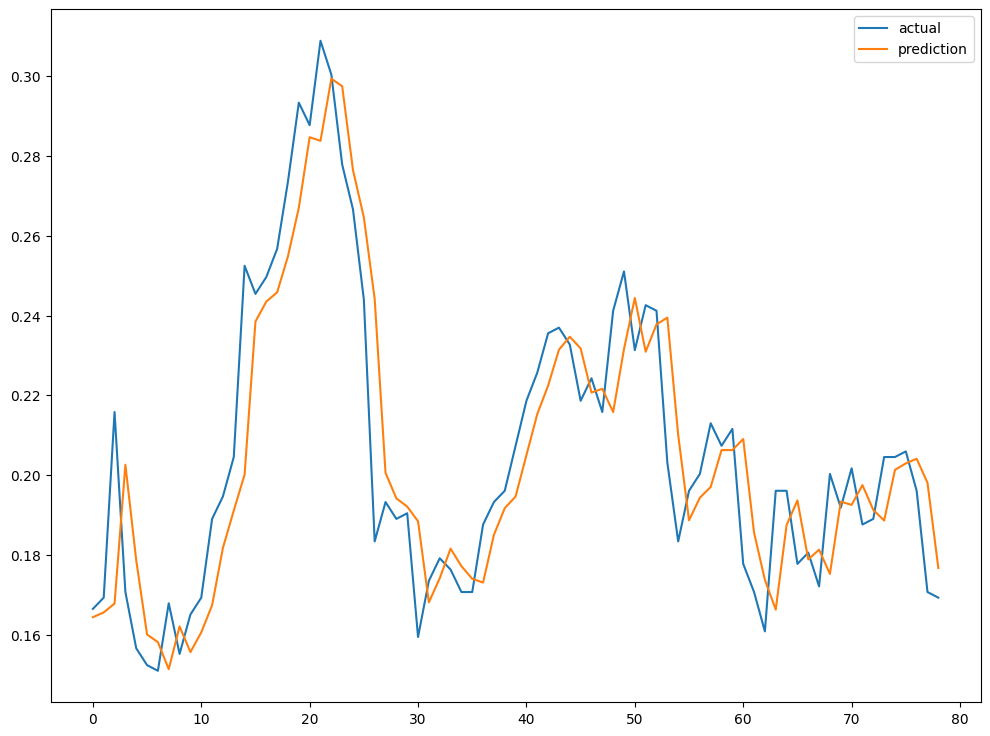

In [37]:
model.load_weights(filename)
pred = model.predict(test_data)
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()